## 『本次練習內容』
#### 使用Xception backbone做 Trnasfer Learning


## 『本次練習目的』
  #### 了解如何使用Transfer Learning
  #### 了解Transfer Learning的優點，可以觀察模型收斂速度

##### 可以自行嘗試多種架構

In [0]:
import keras
from keras import backend as K
from keras.callbacks import EarlyStopping 
from keras.preprocessing import image
from keras.models import Model
from keras.models import Sequential
from keras.layers import Input
from keras.layers import Convolution2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Dense, GlobalAveragePooling2D 
from keras.datasets import cifar10

import tensorflow as tf
import numpy as np
from sklearn.preprocessing import OneHotEncoder


input_tensor = Input(shape=(32, 32, 3))
#include top 決定要不要加入 fully Connected Layer


'''Xception 架構'''
model=keras.applications.xception.Xception(include_top=False, weights='imagenet',
                                           input_tensor=input_tensor,
                                           pooling=None, classes=100)

'''Resnet 50 架構'''
#model=keras.applications.ResNet50(include_top=False, weights='imagenet',
                                    #input_tensor=input_tensor,
                                    #pooling=None, classes=10)

print('Model深度：', len(model.layers))

model.summary()

## 添加層數

In [0]:
'''可以參考Cifar10實作章節'''

# from keras.layers import BatchNormalization

x = model.output
# x = BatchNormalization(axis=1, momentum=0.95, epsilon=0.05)(x)
x = Flatten()(x)
x = Dense(activation="relu", units=2048)(x)

x = Dropout(rate=0.2)(x)
x = Dense(activation="relu", units=512)(x)

x = Dropout(rate=0.2)(x)
x = Dense(activation="relu", units=100)(x)

x = Dropout(rate=0.2)(x)
x = Dense(activation="relu", units=10)(x)

predictions = Dense(activation="softmax", units=10)(x)
model = Model(inputs=model.input, outputs=predictions)
print('Model深度：', len(model.layers))

## 鎖定特定幾層不要更新權重

In [0]:
for layer in model.layers[:116]:
    layer.trainable = False
for layer in model.layers[116:]:
    layer.trainable = True

## 準備 Cifar 10 資料

In [0]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

print(x_train.shape) #(50000, 32, 32, 3)

## Normalize Data
def normalize(X_train,X_test):
        mean = np.mean(X_train,axis=(0,1,2,3))
        std = np.std(X_train, axis=(0, 1, 2, 3))
        X_train = (X_train-mean)/(std+1e-7)
        X_test = (X_test-mean)/(std+1e-7)
        return X_train, X_test
    
    
## Normalize Training and Testset    
x_train, x_test = normalize(x_train, x_test) 

## OneHot Label 由(None, 1)-(None, 10)
## ex. label=2,變成[0,0,1,0,0,0,0,0,0,0]
one_hot=OneHotEncoder()
y_train=one_hot.fit_transform(y_train).toarray()
y_test=one_hot.transform(y_test).toarray()

## Training  
early_stopping = keras.callbacks.EarlyStopping(monitor='loss', patience=0, verbose=0, mode='auto')
 # compile the model (should be done *after* setting layers to non-trainable)
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
model.fit(x_train,y_train,batch_size=50,epochs=30, callbacks=[early_stopping])


In [0]:
import matplotlib.pyplot as plt
his = model.history

fig, ax1 = plt.subplots()
plt.title('Accurcy VS Loss with epochs')
plt.xlabel('epoch')

ax1.set_ylabel('(Loss)', color='black')
ax1.set_ylim(0, 2)
ax1.tick_params(axis='y', labelcolor='black')
ax1.plot(his.epoch,his.history["loss"], label="loss", color='black', alpha=1)
plt.legend(loc='upper left')

ax2 = ax1.twinx()
ax2.set_ylabel('(Accurcy)', color='tab:blue')
ax2.set_ylim(0.25, 1)
ax2.tick_params(axis='y', labelcolor='tab:blue')
ax2.plot(his.epoch, his.history["acc"], label="Accurcy", color='tab:blue', alpha=0.75)
plt.legend(loc='upper right')

# plt.show()

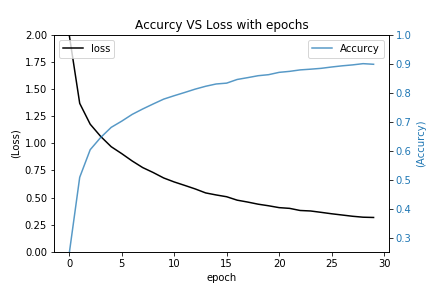

In [6]:
fig.savefig('plot.png')

from google.colab.patches import cv2_imshow
import cv2
img = cv2.imread('plot.png', cv2.IMREAD_UNCHANGED)
cv2_imshow(img)